- Load Files

In [1]:
import pandas as pd 

train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample_submission = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   Basic_Demos-Enroll_Season               20 non-null     object 
 2   Basic_Demos-Age                         20 non-null     int64  
 3   Basic_Demos-Sex                         20 non-null     int64  
 4   CGAS-Season                             10 non-null     object 
 5   CGAS-CGAS_Score                         8 non-null      float64
 6   Physical-Season                         14 non-null     object 
 7   Physical-BMI                            13 non-null     float64
 8   Physical-Height                         13 non-null     float64
 9   Physical-Weight                         13 non-null     float64
 10  Physical-Waist_Circumference            5 non-null      float64


- Capped outliers

In [4]:
# Define a function to cap outliers in a DataFrame
def cap_outliers(df, columns, lower_quantile=0.01, upper_quantile=0.99):
    for col in columns:
        if df[col].dtype in ['float64', 'int64']:
            lower_bound = df[col].quantile(lower_quantile)
            upper_bound = df[col].quantile(upper_quantile)
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

# Identify numeric columns in the train dataset
numeric_columns = train.select_dtypes(include=['float64', 'int64']).columns

# Apply the function to cap outliers in the train dataset
train_capped = cap_outliers(train, numeric_columns)

- Fill NaN Numeric with 0

In [5]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

- Mapping age into 0-1 years is baby, 2-4 years is toddler, 5-11 is child, 12-16 young child, 16-30 young adult, 30-55 adult, 55-120 older .

In [6]:
def map_age(age):
    if 0 <= age <= 1:
        return 'baby'
    elif 2 <= age <= 4:
        return 'toddler'
    elif 5 <= age <= 11:
        return 'child'
    elif 12 <= age <= 16:
        return 'young child'
    elif 17 <= age <= 30:
        return 'young adult'
    elif 31 <= age <= 55:
        return 'adult'
    elif 56 <= age <= 120:
        return 'older'
    else:
        return 'unknown'

train['Age_Group'] = train['Basic_Demos-Age'].apply(map_age)
test['Age_Group'] = test['Basic_Demos-Age'].apply(map_age)

- Mapping height, weight, bmi, heart rate

In [7]:
def map_height(height):
    if height == 0 or pd.isna(height):
        return 'unknown'
    elif height < 50:
        return 'short'
    elif 50 <= height <= 70:
        return 'average'
    else:
        return 'tall'

def map_weight(weight):
    if weight == 0 or pd.isna(weight):
        return 'unknown'
    elif weight < 50:
        return 'underweight'
    elif 50 <= weight <= 100:
        return 'normal'
    else:
        return 'overweight'

def map_bmi(bmi):
    if bmi == 0 or pd.isna(bmi):
        return 'unknown'
    elif bmi < 18.5:
        return 'underweight'
    elif 18.5 <= bmi <= 24.9:
        return 'normal'
    elif 25 <= bmi <= 29.9:
        return 'overweight'
    else:
        return 'obese'

def map_heart_rate(hr):
    if hr == 0 or pd.isna(hr):
        return 'unknown'
    elif hr < 60:
        return 'low'
    elif 60 <= hr <= 100:
        return 'normal'
    else:
        return 'high'

train['Height_Group'] = train['Physical-Height'].apply(map_height)
train['Weight_Group'] = train['Physical-Weight'].apply(map_weight)
train['BMI_Group'] = train['Physical-BMI'].apply(map_bmi)
train['HeartRate_Group'] = train['Physical-HeartRate'].apply(map_heart_rate)

test['Height_Group'] = test['Physical-Height'].apply(map_height)
test['Weight_Group'] = test['Physical-Weight'].apply(map_weight)
test['BMI_Group'] = test['Physical-BMI'].apply(map_bmi)
test['HeartRate_Group'] = test['Physical-HeartRate'].apply(map_heart_rate)

- Mapping into 0 as none, 1 as mild, 2 as moderate, 3 as severe 

In [8]:
def map_sii(sii):
    if sii == 0:
        return 'none'
    elif sii == 1:
        return 'mild'
    elif sii == 2:
        return 'moderate'
    elif sii == 3:
        return 'severe'
    else:
        return 'unknown'

train['sii_category'] = train['sii'].apply(map_sii)

- Mapping PreInt_EduHx-computerinternet_hoursday into Low, Moderate, High

In [9]:
def map_computer_internet_hours(hours):
    if hours == 0:
        return 'none'
    elif 0 < hours <= 2:
        return 'low'
    elif 2 < hours <= 5:
        return 'moderate'
    elif hours > 5:
        return 'high'
    else:
        return 'unknown'

train['ComputerInternet_Usage'] = train['PreInt_EduHx-computerinternet_hoursday'].apply(map_computer_internet_hours)
test['ComputerInternet_Usage'] = test['PreInt_EduHx-computerinternet_hoursday'].apply(map_computer_internet_hours)

- Calculate the most common problem category for children 

In [10]:
children_data = train[train['Age_Group'] == 'child']

# Choose "sii_category" represents the problem category
most_common_problem = children_data['sii_category'].value_counts()
most_common_problem

sii_category
none        2046
mild         426
moderate     154
severe         2
Name: count, dtype: int64

- Create a pie chart for the most common problem categories for children

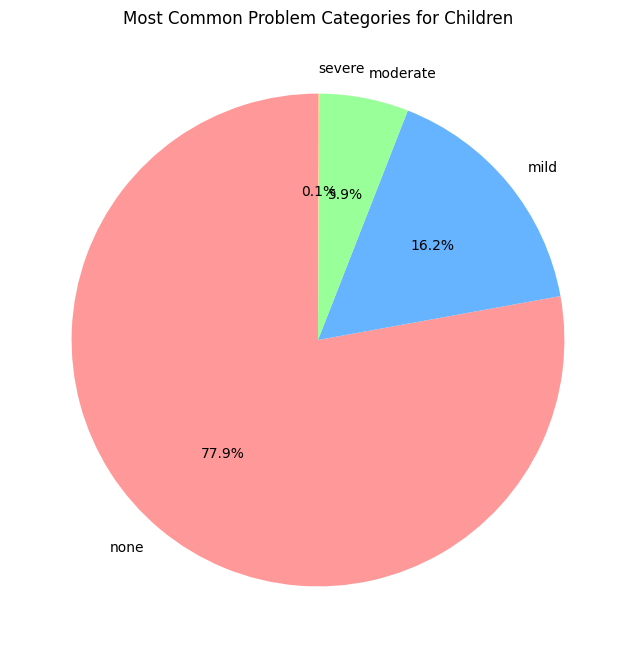

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
most_common_problem.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Most Common Problem Categories for Children')
plt.ylabel('')  # Remove y-axis label
plt.show()

- Count the number of individuals with problems in these age groups

In [12]:
# Filter data for age groups from 'young adult' to 'older'
adult_data = train[train['Age_Group'].isin(['young adult', 'adult', 'older'])]

# Count the number of individuals with problems in these age groups
problem_counts = adult_data['sii_category'].value_counts()
problem_counts

sii_category
none        171
mild         53
moderate     44
severe        8
Name: count, dtype: int64

In [13]:
problem_total = problem_counts.sum()
problem_percentage = (problem_counts / problem_total) * 100
problem_percentage

sii_category
none        61.956522
mild        19.202899
moderate    15.942029
severe       2.898551
Name: count, dtype: float64

- Create a bar chart for the problem percentages from young adult to older age groups

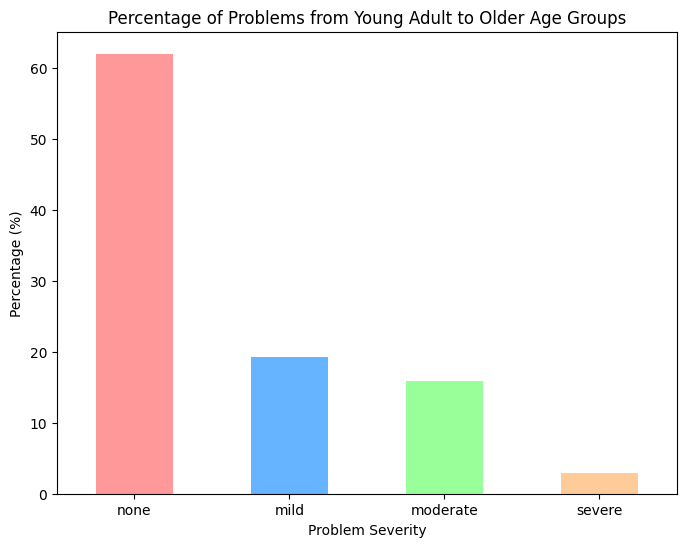

In [14]:
plt.figure(figsize=(8, 6))
problem_percentage.plot(kind='bar', color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
plt.title('Percentage of Problems from Young Adult to Older Age Groups')
plt.xlabel('Problem Severity')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.show()

- Calculate the percentage of computer/internet usage by age category, season, and sex

In [15]:
sds_percentage = train.groupby(['Age_Group', 'Basic_Demos-Sex', 'Basic_Demos-Enroll_Season'])['SDS-SDS_Total_Raw'].sum() / train['SDS-SDS_Total_Raw'].sum() * 100
sds_percentage = sds_percentage.reset_index(name='Percentage')
sds_percentage

,Age_Group,Basic_Demos-Sex,Basic_Demos-Enroll_Season,Percentage
0,child,0,Fall,11.191137
1,child,0,Spring,12.769853
2,child,0,Summer,9.991686
3,child,0,Winter,10.853908
4,child,1,Fall,5.646947
5,child,1,Spring,6.473671
6,child,1,Summer,5.837514
7,child,1,Winter,6.033686
8,young adult,0,Fall,0.555820
9,young adult,0,Spring,0.399817


- Create a bar chart to visualize the percentage of computer/internet usage by age category, season, and sex

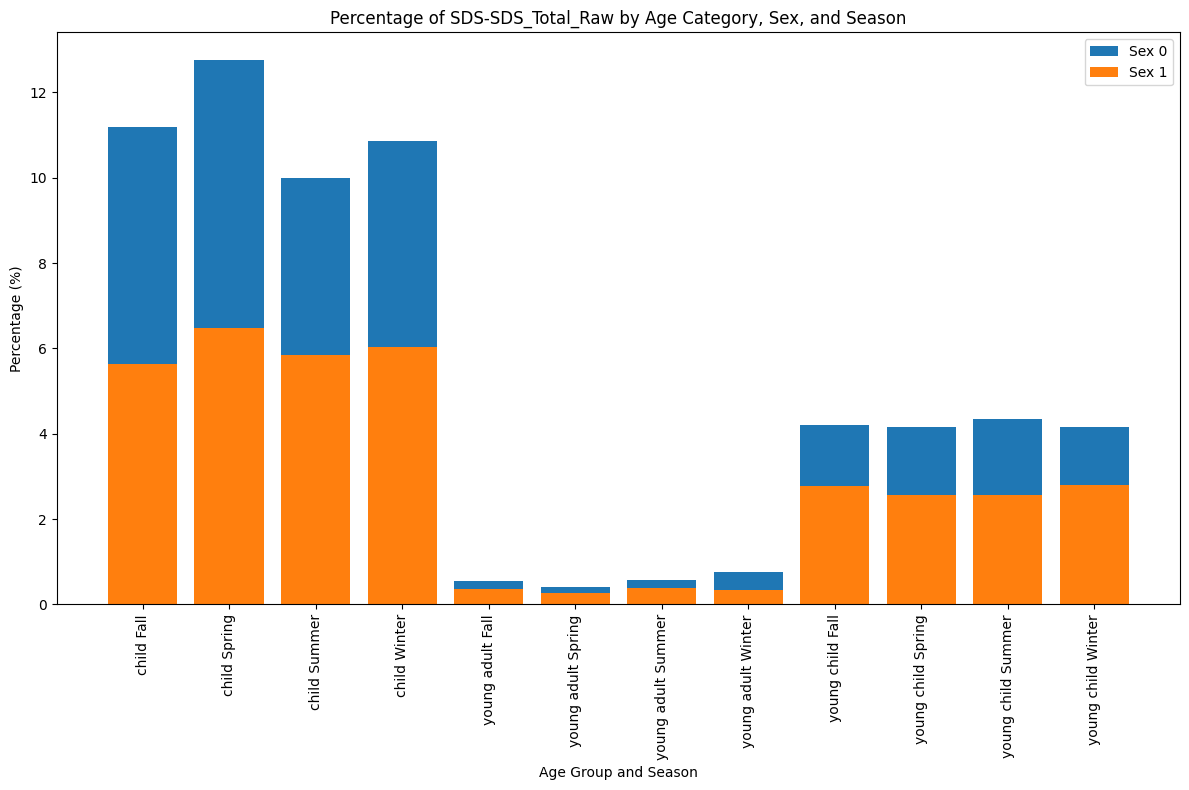

In [16]:
plt.figure(figsize=(12, 8))
for sex in sds_percentage['Basic_Demos-Sex'].unique():
    subset = sds_percentage[sds_percentage['Basic_Demos-Sex'] == sex]
    plt.bar(subset['Age_Group'] + ' ' + subset['Basic_Demos-Enroll_Season'],
            subset['Percentage'], label=f'Sex {sex}')

plt.title('Percentage of SDS-SDS_Total_Raw by Age Category, Sex, and Season')
plt.xlabel('Age Group and Season')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

- Mapping SDS-SDS_Total_Raw to normal or not normal

In [17]:
def map_sds(sds_raw):
    if sds_raw == 0 or pd.isna(sds_raw):
        return 'unknown'
    elif sds_raw < 50:
        return 'normal'
    else:
        return 'not normal'

train['SDS_Category'] = train['SDS-SDS_Total_Raw'].apply(map_sds)
test['SDS_Category'] = test['SDS-SDS_Total_Raw'].apply(map_sds)

- Mapping CGAS-CGAS_Score mapping into lower, moderate and higher 

In [18]:
def map_cgas_score(score):
    if score == 0 or pd.isna(score):
        return 'unknown'
    elif score <= 40:
        return 'lower'
    elif 41 <= score <= 70:
        return 'moderate'
    else:
        return 'higher'

train['CGAS_Category'] = train['CGAS-CGAS_Score'].apply(map_cgas_score)
test['CGAS_Category'] = test['CGAS-CGAS_Score'].apply(map_cgas_score)

- Normalize the 'sii' column to use as the target variable

In [19]:
train['sii_normalized'] = (train['sii'] - train['sii'].min()) / (train['sii'].max() - train['sii'].min())

- Setup features and target

In [20]:
new_features = ['Age_Group',
                'BMI_Group',
                'CGAS_Category',
                'ComputerInternet_Usage',
                'HeartRate_Group',
                'Height_Group',
                'SDS_Category',
                'Weight_Group',
                'sii_category'] 

In [21]:
train_features = train[new_features]

In [22]:
target = train['sii_normalized']
target

0       0.666667
1       0.000000
2       0.000000
3       0.333333
4       0.000000
          ...   
3955    0.333333
3956    0.000000
3957    0.333333
3958    0.000000
3959    0.000000
Name: sii_normalized, Length: 3960, dtype: float64

- Encode the features

In [23]:
train_features = train[new_features]

In [24]:
label_encoded_features = train_features.copy()

In [25]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for column in label_encoded_features.columns:
    le = LabelEncoder()
    label_encoded_features[column] = le.fit_transform(label_encoded_features[column])
    label_encoders[column] = le

In [26]:
X = train_features
y = target

- Split the data into training and validation sets

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(label_encoded_features, target, test_size=0.25, random_state=42)

- Standardize the features

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

- Define the neural network model architecture

In [29]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

def build_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))  # Regression output
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build and train the model
model = build_model(input_dim=X_train_scaled.shape[1])

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
model.fit(
    X_train_scaled, np.array(y_train),
    epochs=30, batch_size=32,
    validation_data=(X_val_scaled, np.array(y_val)),
    callbacks=[early_stop], verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0755 - val_loss: 0.0351
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0385 - val_loss: 0.0319
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0334 - val_loss: 0.0296
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0304 - val_loss: 0.0265
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0247 - val_loss: 0.0210
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0217 - val_loss: 0.0170
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182 - val_loss: 0.0138
Epoch 8/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153 - val_loss: 0.0113
Epoch 9/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0125 - val_loss: 0.0074
Epoch 10/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106 - val_loss: 0.0056
Epoch 11/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0094 - val_loss: 0.0038
Epoch 12/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077 - val_l

In [30]:
# Convert the target variable to a numpy array
y_train_tensor = np.array(y_train)
y_val_tensor = np.array(y_val)

In [31]:
# Predict on the validation set
y_val_pred = model.predict(X_val_scaled).flatten()

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [32]:
# Discretize the true and predicted values into 'none', 'mild', 'moderate', 'severe'
def discretize_target(y, bins):
    return np.digitize(y, bins=bins, right=True)

In [33]:
# Define bins for discretization
bins = [0.25, 0.5, 0.75]

# Discretize the true and predicted values
y_val_discrete = discretize_target(np.array(y_val), bins)
y_val_pred_discrete = discretize_target(y_val_pred, bins)

- Calculate Cohen's kappa weighted score

In [34]:
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

weighted_kappa = cohen_kappa_score(y_val_discrete, y_val_pred_discrete, weights='quadratic')
weighted_kappa

0.9990289338478349

- Map the bins to these labels

In [35]:
bin_labels = ['none', 'mild', 'moderate', 'severe']

- Visualize the confusion matrix 

Text(0.5, 36.72222222222221, 'Predicted Labels')

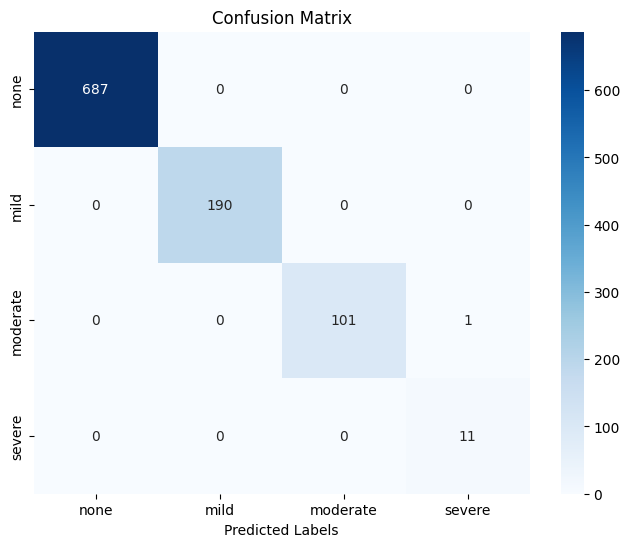

In [36]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val_discrete, y_val_pred_discrete)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['none', 'mild', 'moderate', 'severe'], yticklabels=['none', 'mild', 'moderate', 'severe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')

In [37]:
# Save the trained model
model.save('trained_neural_network_model.h5')